In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 


Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean
import random

## create basis & function demo

In [3]:
np.random.seed(1234567)

In [4]:
def simulate_random_dag(d: int,
                        degree: float,
                        w_range: tuple = (1.0, 1.0)) -> nx.DiGraph:
    """Simulate random DAG with an expected degree by Erdos-Renyi model.
        
        Args:
        d: number of nodes
        degree: expected node degree, in + out
        w_range: weight range +/- (low, high)
        
        Returns:
        G: weighted DAG
        """
    prob = float(degree) / (d - 1)
    B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
    
    # random permutation
    P = np.random.permutation(np.eye(d, d))  # permutes first axis only
    B_perm = P.T.dot(B).dot(P)
    U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
    U[np.random.rand(d, d) < 0.5] *= -1
    W = (B_perm != 0).astype(float) * U
    
    # remove all in-edges (from precedent nodes) of the first node as A
    W[:, 0] = 0
    # remove all out-edges (from descendent nodes) of the last node as Y
    W[d-1, :] = 0
    # the remained nodes are the mediators M; and reset mediators if it has higher topological order than A or lower order than Y.
    ordered_vertices = list(nx.topological_sort(nx.DiGraph(W)))
    j = 1
    while j < d - 1:
        if  ordered_vertices.index(j) < ordered_vertices.index(0):
            W[j, 1:(d - 1)] = np.zeros (d - 2)
        if  ordered_vertices.index(j) > ordered_vertices.index(d - 1):
            W[1:(d - 1), j] = np.zeros (d - 2)
        j = j + 1
    #print("True weighted adjacency matrix B:\n", W)
    G = nx.DiGraph(W)
    calculate_effect(W)
    return W

In [5]:
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
base_DAG

The total effect (TE): 0.0
The natural direct effect (DE): 0.0
The natural indirect effect (IE): 0.0
The natural direct effect for mediators (DM): [ 0.  0. -0.]
The natural direct effect for mediators (IM): [0. 0. 0.]


array([[ 0., -1., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  0., -0.],
       [ 0.,  1., -0.,  0.,  1.],
       [ 0., -0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [6]:
random.seed(1234567)
pick_element=random.sample(range(5), 2) ## pick two location to mutate
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]

In [22]:
pick_1

(2, 4)

In [23]:
pick_2

(0, 3)

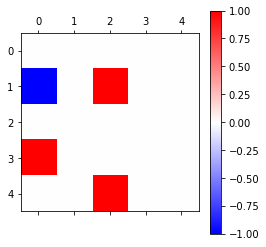

In [7]:
plt.matshow(base_DAG.T, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

In [8]:
import math 
def cos(x):
    return ((math.cos(x/6*math.pi))/4+1)*0.8

In [9]:
def quadratic(x):
    return(-5+(10-x)**2)/200+0.5

## create data

In [10]:
def data_create(seed,time_stamp,set_graph):
  np.random.seed(seed)
  x = np.array(range(0, time_stamp))
  #y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x]) #generate coefficient
  y=np.array([cos(i) for i in x])
  z=np.array([quadratic(i) for i in x])##edited to have multiple
  base_DAG=set_graph 
  base_DAG[pick_1]=y[0]##edited to be coeffcient with error
  base_DAG[pick_2]=z[0]###multiple
  base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
  X_all = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
  for i in range(1,time_stamp):
      base_DAG[pick_1]=y[i]##edited to be coeffcient with error
      base_DAG[pick_2]=z[i]###multiple
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      X = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
      X_all=np.append(X_all,X,axis=0)
      print(base_DAG)
  return X_all

## piecewise ANOCA

In [12]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import pickle
import os
import random

import torch.optim as optim
from torch.optim import lr_scheduler
import math
from utils import *

from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed


In [13]:
def train(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            h1_B = fun_h1_B(origin_B)
            h2_B = fun_h2_B(origin_B)

            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


In [14]:
import time

In [15]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [16]:
n = 30 # The number of samples of data.
d = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.

n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list=np.zeros((n_times,time_stamp,d,d))
B_list=np.zeros((n_times,d, d))
FDR_total=[]
TPR_total=[]
SHD_total=[]
time_list=[]
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp,base_DAG) #create data
  average_list=np.zeros((time_stamp,d, d))
  FDR_list_piece=[]
  TPR_list_piece=[]
  SHD_list_piece=[]
  #base_DAG=np.zeros((5, 5))
  ####estimate at each time_stamp####
  timestart=time.time()
  for j in range(time_stamp):
  # ----------- Configurations:
      k_max_iter = int(1e2) # The max iteration number for searching parameters.
      original_lr = 3e-3  # Initial learning rate.
      encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
      decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
      temp = 0.5 # Temperature for Gumbel softmax.
      factor = True # Factor graph model.
      encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
      decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
      tau_B = 0. # Coefficient for L-1 norm of matrix B.
      lambda1 = 0. # Coefficient for DAG constraint h1(B).
      lambda2 = 0. # Coefficient for identification constraint h2(B).
      c_B = 1 # Coefficient for absolute value h1(B).
      d_B = 1 # Coefficient for absolute value h2(B).
      h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
      h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
      lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
      gamma = 1.0 # LR decay factor. 
      ######################


      X=X_all[(j*30):(j*30+30),:]


      np.random.seed(seed)
      random.seed(seed)
      torch.manual_seed(seed)
      feat_train = torch.FloatTensor(X)
      feat_valid = torch.FloatTensor(X)
      feat_test = torch.FloatTensor(X)

      # Reconstruct itself
      train_data = TensorDataset(feat_train, feat_train)
      valid_data = TensorDataset(feat_valid, feat_train)
      test_data = TensorDataset(feat_test, feat_train)

      train_loader = DataLoader(train_data, batch_size = batch_size)
      valid_loader = DataLoader(valid_data, batch_size = batch_size)
      test_loader = DataLoader(test_data, batch_size = batch_size)

      # ----------- Load modules:
      off_diag = np.ones([d, d]) - np.eye(d) # Generate off-diagonal interaction graph
      rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
      rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
      rel_rec = torch.DoubleTensor(rel_rec)
      rel_send = torch.DoubleTensor(rel_send)
      adj_A = np.zeros((d, d)) # Add adjacency matrix

      encoder = MLPEncoder(d * x_dims, x_dims, encoder_hidden,
                              int(z_dims), adj_A,
                              batch_size = batch_size,
                              do_prob = encoder_dropout, factor = factor).double()
      decoder = MLPDecoder(d * x_dims,
                              z_dims, x_dims, encoder,
                              data_variable_size = d,
                              batch_size = batch_size,
                              n_hid=decoder_hidden,
                              do_prob=decoder_dropout).double()

      # ----------- Set up optimizer:
      optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
      scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                      gamma = gamma)

      rel_rec = Variable(rel_rec)
      rel_send = Variable(rel_send)

      # ----------- Main:
      best_ELBO_loss = np.inf
      best_NLL_loss = np.inf
      best_MSE_loss = np.inf
      h1_B_new = torch.tensor(1.)
      h2_B_new = 1
      h1_B_old = np.inf
      h2_B_old = np.inf
      lr = original_lr

      try:
          for step_k in range(k_max_iter):
              while c_B * d_B < 1e+20:
                  for epoch in range(epochs):
                      old_lr = lr 
                      ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr)

                      if ELBO_loss < best_ELBO_loss:
                          best_ELBO_loss = ELBO_loss

                      if NLL_loss < best_NLL_loss:
                          best_NLL_loss = NLL_loss

                      if MSE_loss < best_MSE_loss:
                          best_MSE_loss = MSE_loss

                  if ELBO_loss > 2 * best_ELBO_loss:
                      break

                  # Update parameters
                  B_new = origin_B.data.clone()
                  h1_B_new = fun_h1_B(B_new)
                  h2_B_new = fun_h2_B(B_new)
                  if h1_B_new.item() > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                      c_B *= 10
                      d_B *= 10
                  elif h1_B_new.item() > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                      c_B *= 10
                  elif h1_B_new.item() < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                      d_B *= 10
                  else:
                      break

              # Update parameters    
              h1_B_old = h1_B_new.item()
              h2_B_old = h2_B_new
              lambda1 += c_B * h1_B_new.item()
              lambda2 += d_B * h2_B_new

              if h1_B_new.item() <= h1_tol and h2_B_new <= h2_tol:
                  break

      except KeyboardInterrupt:
          print('KeyboardInterrupt')

      predB = np.matrix(origin_B.data.clone().numpy())
      print('Best ELBO Loss :', best_ELBO_loss)
      print('Best NLL Loss :', best_NLL_loss)
      print('Best MSE Loss :', best_MSE_loss)
      #calculate_effect(predB)
      print(j)
      average_list[j,:,:]=predB
      #FDR, TPR, SHD
      #base_DAG[0,4]=cos(j)
      #base_DAG[2,3]=quadratic(j)
      #base_DAG[3,4]=-1 ###constant
      #base_DAG[2,4]=-1
      #base_DAG[base_DAG<0.4]=0##change base_DAG
     #FDR, TPR, SHD
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=predB
      a[abs(a)<0.3] = 0##threhold
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)
      FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)



  np.save("full_20_30_ANOCA",average_coef_list)
  average_coef_list[replicate,:,:,:]=average_list#save all matrix
  FDR_total.append(mean(FDR_list_piece))
  TPR_total.append(mean(TPR_list_piece))
  SHD_total.append(mean(SHD_list_piece))
  timeend=time.time()
  time_list.append(timeend-timestart)
  #####write at every epoch
  df = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
  df["FDR"]=FDR_total
  df["TPR"]=TPR_total
  df["SHD"]=SHD_total
  df["time"]=time_list
  #df.to_csv("cos_rep5.csv")
  print(replicate)

[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.     

D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.0006375138291448848
Best NLL Loss : 5.682566662111643e-07
Best MSE Loss : 2.2730266648446564e-07
0
Best ELBO Loss : 0.0008700904725275906
Best NLL Loss : 1.100437577503894e-06
Best MSE Loss : 4.4017503100155763e-07
1
Best ELBO Loss : 0.0010744926052220318
Best NLL Loss : 1.1126477811119735e-06
Best MSE Loss : 4.4505911244478944e-07
2
Best ELBO Loss : 0.0007454372492845673
Best NLL Loss : 8.409598901841199e-07
Best MSE Loss : 3.363839560736481e-07
3
Best ELBO Loss : 0.0007648417309497006
Best NLL Loss : 7.665355938033091e-07
Best MSE Loss : 3.0661423752132367e-07
4
Best ELBO Loss : 0.0008962837977202788
Best NLL Loss : 1.4131329656312184e-06
Best MSE Loss : 5.652531862524874e-07
5
Best ELBO Loss : 0.0007327501795897722
Best NLL Loss : 3.59925058969883e-07
Best MSE Loss : 1.439700235879532e-07
6
Best ELBO Loss : 0.0009271176599594329
Best NLL Loss : 9.068966607048083e-07
Best MSE Loss : 3.6275866428192335e-07
7
Best ELBO Loss : 0.0009179430592191488
Best NLL Loss : 1.4

Best ELBO Loss : 0.0015435995616905934
Best NLL Loss : 2.183320088050717e-06
Best MSE Loss : 8.733280352202866e-07
0
Best ELBO Loss : 0.0009435286748989594
Best NLL Loss : 1.8320719497364022e-06
Best MSE Loss : 7.328287798945607e-07
1
Best ELBO Loss : 0.0016505644813326742
Best NLL Loss : 1.7384001799264692e-06
Best MSE Loss : 6.953600719705878e-07
2
Best ELBO Loss : 0.0013179913323098792
Best NLL Loss : 2.0832416903702847e-06
Best MSE Loss : 8.332966761481138e-07
3
Best ELBO Loss : 0.0010588460164515127
Best NLL Loss : 6.834529421558287e-07
Best MSE Loss : 2.733811768623315e-07
4
Best ELBO Loss : 0.0016281765583797071
Best NLL Loss : 2.3183048788895087e-06
Best MSE Loss : 9.273219515558036e-07
5
Best ELBO Loss : 0.0011499793279129617
Best NLL Loss : 1.8874584750280158e-06
Best MSE Loss : 7.549833900112064e-07
6
Best ELBO Loss : 0.0010625614297808774
Best NLL Loss : 7.274504973431915e-07
Best MSE Loss : 2.909801989372766e-07
7
Best ELBO Loss : 0.0012650230980057703
Best NLL Loss : 1.93

Best ELBO Loss : 0.000941565573742223
Best NLL Loss : 1.0149506767259503e-06
Best MSE Loss : 4.059802706903801e-07
0
Best ELBO Loss : 0.000978337370136335
Best NLL Loss : 1.1276226295777538e-06
Best MSE Loss : 4.510490518311015e-07
1
Best ELBO Loss : 0.0010289838723591344
Best NLL Loss : 1.116760475052959e-06
Best MSE Loss : 4.4670419002118366e-07
2
Best ELBO Loss : 0.0011110496035281869
Best NLL Loss : 6.66239946709171e-06
Best MSE Loss : 2.664959786836684e-06
3
Best ELBO Loss : 0.0007517097012460537
Best NLL Loss : 6.70718969751736e-07
Best MSE Loss : 2.6828758790069445e-07
4
Best ELBO Loss : 0.001111104794781907
Best NLL Loss : 1.311052885740867e-06
Best MSE Loss : 5.24421154296347e-07
5
Best ELBO Loss : 0.0010081335821150235
Best NLL Loss : 6.449195643245141e-07
Best MSE Loss : 2.579678257298056e-07
6
Best ELBO Loss : 0.0009769576117040445
Best NLL Loss : 1.2136581841275609e-06
Best MSE Loss : 4.854632736510245e-07
7
Best ELBO Loss : 0.0010822453483580405
Best NLL Loss : 1.32530475

Best ELBO Loss : 0.001163407463388964
Best NLL Loss : 9.32534368443742e-07
Best MSE Loss : 3.73013747377497e-07
0
Best ELBO Loss : 0.0009622574135453103
Best NLL Loss : 8.994649878703442e-07
Best MSE Loss : 3.5978599514813764e-07
1
Best ELBO Loss : 0.0010834374872447494
Best NLL Loss : 9.994557365115932e-07
Best MSE Loss : 3.9978229460463717e-07
2
Best ELBO Loss : 0.0011913080587177506
Best NLL Loss : 1.1770003280028639e-06
Best MSE Loss : 4.7080013120114556e-07
3
Best ELBO Loss : 0.0013953769473173656
Best NLL Loss : 1.4525073420589558e-06
Best MSE Loss : 5.810029368235825e-07
4
Best ELBO Loss : 0.001073440038397683
Best NLL Loss : 1.1016841534738112e-06
Best MSE Loss : 4.406736613895244e-07
5
Best ELBO Loss : 0.0010032929846196985
Best NLL Loss : 1.1209557134445328e-06
Best MSE Loss : 4.483822853778132e-07
6
Best ELBO Loss : 0.0012917713494603775
Best NLL Loss : 3.067244688447804e-06
Best MSE Loss : 1.2268978753791217e-06
7
Best ELBO Loss : 0.0012840656841397427
Best NLL Loss : 1.422

Best ELBO Loss : 0.0013174065635181817
Best NLL Loss : 1.023422172074445e-06
Best MSE Loss : 4.0936886882977803e-07
0
Best ELBO Loss : 0.001007269895420862
Best NLL Loss : 1.101142685845362e-06
Best MSE Loss : 4.404570743381448e-07
1
Best ELBO Loss : 0.0010176582340306296
Best NLL Loss : 1.0390903742876134e-06
Best MSE Loss : 4.1563614971504535e-07
2
Best ELBO Loss : 0.0009192721030926985
Best NLL Loss : 8.099976130447514e-07
Best MSE Loss : 3.239990452179005e-07
3
Best ELBO Loss : 0.0009003250181716111
Best NLL Loss : 1.1136315202960008e-06
Best MSE Loss : 4.454526081184004e-07
4
Best ELBO Loss : 0.0009503246227518301
Best NLL Loss : 1.1142961874573738e-06
Best MSE Loss : 4.457184749829497e-07
5
Best ELBO Loss : 0.0012068160029205907
Best NLL Loss : 1.2260615773379745e-06
Best MSE Loss : 4.904246309351899e-07
6
Best ELBO Loss : 0.0009292577305334427
Best NLL Loss : 6.219315727017397e-07
Best MSE Loss : 2.4877262908069585e-07
7
Best ELBO Loss : 0.0009744018264718726
Best NLL Loss : 1.0

Best ELBO Loss : 0.0010075767293883768
Best NLL Loss : 9.15329347796509e-07
Best MSE Loss : 3.6613173911860364e-07
0
Best ELBO Loss : 0.001134799008125245
Best NLL Loss : 1.202705805280894e-06
Best MSE Loss : 4.810823221123576e-07
1
Best ELBO Loss : 0.0011235765322695592
Best NLL Loss : 1.2169812230038478e-06
Best MSE Loss : 4.867924892015391e-07
2
Best ELBO Loss : 0.0008942699381037135
Best NLL Loss : 7.376092984308987e-07
Best MSE Loss : 2.950437193723595e-07
3
Best ELBO Loss : 0.0009584897670978327
Best NLL Loss : 1.1195649177130801e-06
Best MSE Loss : 4.4782596708523204e-07
4
Best ELBO Loss : 0.0009617242368534611
Best NLL Loss : 1.122379216996363e-06
Best MSE Loss : 4.4895168679854516e-07
5
Best ELBO Loss : 0.0012000080855137927
Best NLL Loss : 1.7414746907728037e-06
Best MSE Loss : 6.965898763091213e-07
6
Best ELBO Loss : 0.000847016395283761
Best NLL Loss : 8.721688705410536e-07
Best MSE Loss : 3.488675482164215e-07
7
Best ELBO Loss : 0.0011419481540804854
Best NLL Loss : 1.4486

Best ELBO Loss : 0.00121842807752141
Best NLL Loss : 1.3383755760131492e-06
Best MSE Loss : 5.353502304052595e-07
0
Best ELBO Loss : 0.0009697152257417039
Best NLL Loss : 1.2509921999205416e-06
Best MSE Loss : 5.003968799682167e-07
1
Best ELBO Loss : 0.0011468429654253043
Best NLL Loss : 8.571724679628128e-07
Best MSE Loss : 3.42868987185125e-07
2
Best ELBO Loss : 0.0008480583660031857
Best NLL Loss : 1.1590187357348614e-06
Best MSE Loss : 4.636074942939444e-07
3
Best ELBO Loss : 0.0011174717878672327
Best NLL Loss : 9.188513819986034e-07
Best MSE Loss : 3.6754055279944135e-07
4
Best ELBO Loss : 0.0009125100857009271
Best NLL Loss : 1.2330885152758058e-06
Best MSE Loss : 4.932354061103223e-07
5
Best ELBO Loss : 0.0009078811074196622
Best NLL Loss : 8.525842631909549e-07
Best MSE Loss : 3.41033705276382e-07
6
Best ELBO Loss : 0.0008705332972710644
Best NLL Loss : 1.1102595422175445e-06
Best MSE Loss : 4.441038168870178e-07
7
Best ELBO Loss : 0.0010745341216792297
Best NLL Loss : 8.95382

Best ELBO Loss : 0.001306848382343665
Best NLL Loss : 4.677366991021928e-06
Best MSE Loss : 1.8709467964087712e-06
0
Best ELBO Loss : 0.0011173674714804152
Best NLL Loss : 1.2746240878659856e-06
Best MSE Loss : 5.098496351463941e-07
1
Best ELBO Loss : 0.0010327285206071372
Best NLL Loss : 1.2371282990198452e-06
Best MSE Loss : 4.948513196079379e-07
2
Best ELBO Loss : 0.0010521923923125617
Best NLL Loss : 1.1574337292299838e-06
Best MSE Loss : 4.6297349169199345e-07
3
Best ELBO Loss : 0.0009896709054879752
Best NLL Loss : 1.3150694721869964e-06
Best MSE Loss : 5.260277888747985e-07
4
Best ELBO Loss : 0.001090658113252785
Best NLL Loss : 1.177381857835376e-06
Best MSE Loss : 4.709527431341504e-07
5
Best ELBO Loss : 0.0010503661513694333
Best NLL Loss : 1.9333690311545352e-06
Best MSE Loss : 7.733476124618139e-07
6
Best ELBO Loss : 0.001245422754321695
Best NLL Loss : 1.2848055027648475e-06
Best MSE Loss : 5.13922201105939e-07
7
Best ELBO Loss : 0.000982308705013048
Best NLL Loss : 1.0697

Best ELBO Loss : 0.0017780551343424382
Best NLL Loss : 2.9294193117499783e-06
Best MSE Loss : 1.171767724699991e-06
0
Best ELBO Loss : 0.0016796354128556358
Best NLL Loss : 2.341355364426148e-06
Best MSE Loss : 9.365421457704593e-07
1
Best ELBO Loss : 0.0018052748849316125
Best NLL Loss : 2.144524231292572e-06
Best MSE Loss : 8.578096925170286e-07
2
Best ELBO Loss : 0.0015288149694099864
Best NLL Loss : 3.1163404798340057e-06
Best MSE Loss : 1.2465361919336018e-06
3
Best ELBO Loss : 0.001452139151541114
Best NLL Loss : 3.0145854045608293e-06
Best MSE Loss : 1.2058341618243315e-06
4
Best ELBO Loss : 0.0014133337027365837
Best NLL Loss : 3.165937013586906e-06
Best MSE Loss : 1.2663748054347626e-06
5
Best ELBO Loss : 0.001577784305093941
Best NLL Loss : 3.088800568861476e-06
Best MSE Loss : 1.2355202275445902e-06
6
Best ELBO Loss : 0.0013234477440148059
Best NLL Loss : 3.387993295162308e-06
Best MSE Loss : 1.3551973180649227e-06
7
Best ELBO Loss : 0.0012935294994635782
Best NLL Loss : 2.2

Best ELBO Loss : 0.0012954204359333574
Best NLL Loss : 1.6025640915902954e-05
Best MSE Loss : 6.410256366361181e-06
0
Best ELBO Loss : 0.0014382237741694093
Best NLL Loss : 1.1897653272808873e-05
Best MSE Loss : 4.75906130912355e-06
1
Best ELBO Loss : 0.0010376765216087694
Best NLL Loss : 1.2418479644384404e-06
Best MSE Loss : 4.967391857753761e-07
2
Best ELBO Loss : 0.000982873912585172
Best NLL Loss : 1.6698837600344082e-06
Best MSE Loss : 6.679535040137632e-07
3
Best ELBO Loss : 0.0013735534035517834
Best NLL Loss : 2.337141137816163e-06
Best MSE Loss : 9.348564551264652e-07
4
Best ELBO Loss : 0.0011526726811663128
Best NLL Loss : 1.967525485541353e-06
Best MSE Loss : 7.870101942165412e-07
5
Best ELBO Loss : 0.0016109770122589235
Best NLL Loss : 1.6558213323764702e-05
Best MSE Loss : 6.6232853295058805e-06
6
Best ELBO Loss : 0.0013557828852049864
Best NLL Loss : 8.346756261428338e-06
Best MSE Loss : 3.3387025045713344e-06
7
Best ELBO Loss : 0.0012531847868396905
Best NLL Loss : 1.39

In [18]:
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
df["time"]=time_list

df

,FDR,TPR,SHD,time
0,0.417857,0.675,3.3,345.329850
1,0.296667,0.725,2.4,351.268898
2,0.158333,0.625,2.1,363.942079
3,0.241667,0.825,1.8,366.317927
4,0.161667,0.625,2.1,405.523110
5,0.441429,0.775,3.3,352.127063
6,0.248333,0.650,2.4,361.284709
7,0.333333,0.625,3.0,377.203782
8,0.480952,0.900,3.7,385.866731
9,0.158333,0.625,2.1,382.005145


In [24]:
df.mean()

FDR       0.254159
TPR       0.714167
SHD       2.353333
time    367.732798
dtype: float64

In [109]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [194]:
pick_1

(2, 4)

In [195]:
pick_2

(0, 3)

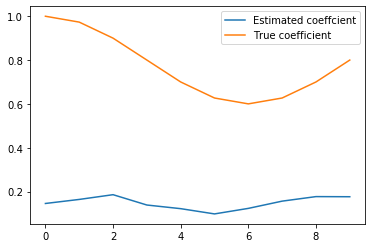

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,2,4],0))
plt.plot(range(time_stamp),[cos(i) for i in range(time_stamp)])
# Function add a legend  
plt.legend(["Estimated coeffcient", "True coefficient"])
  
# function to show the plot
plt.show()

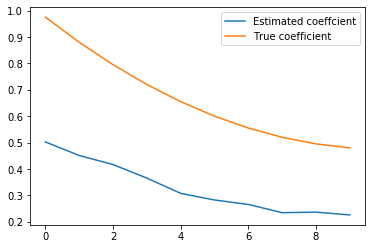

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,0,3],0))
plt.plot(range(time_stamp),[quadratic(i) for i in range(time_stamp)])
# Function add a legend  
plt.legend(["Estimated coeffcient", "True coefficient"])
  
# function to show the plot
plt.show()

In [135]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

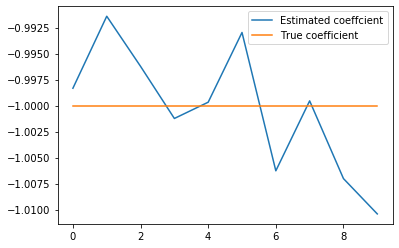

In [21]:
plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,0,1],0))
plt.plot(range(time_stamp),[-1]*time_stamp)
# Function add a legend  
plt.legend(["Estimated coeffcient", "True coefficient"])
  
# function to show the plot
plt.show()

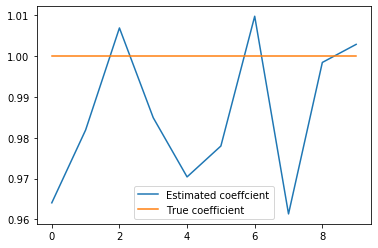

In [199]:
plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,2,1],0))
plt.plot(range(time_stamp),[1]*time_stamp)
# Function add a legend  
plt.legend(["Estimated coeffcient", "True coefficient"])
  
# function to show the plot
plt.show()

# new method

In [19]:
# ----------- Configurations:
#time_stamp=10
n_timestamp=time_stamp
sample__time=30##sample per timepoint
n = time_stamp*sample__time # The number of samples of data.
n_var = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.


In [20]:
n_timestamp

10

In [21]:
sample__time

30

In [22]:
def create_X(X):
    X_sum=np.zeros((sample__time, n_var,1))
    for i in range(0,n_timestamp):
        X_sum=X_sum+X[(sample__time*i):(sample__time*(i+1)),:] #sum i
        print((sample__time*i),(sample__time*(i+1)))
    return(X_sum)

In [23]:
def create_D(X,spline_list):
    D_all=np.zeros((sample__time, n_var*len(spline_list),1))
    for j in range(len(spline_list)):
        D_sum=np.zeros((sample__time, n_var,1))
        for i in range(0,n_timestamp):
            D_sum=D_sum+X[(sample__time*i):(sample__time*(i+1)),:]*spline_list[j](i)#sum X_i *f(i)
        ##horizontally append
        D_all[:,n_var*j:n_var*(j+1),:]=D_sum
        #print((n_features*j,n_features*(j+1)))
    return(D_all)

In [24]:
def spl_const(x):
    return(1)

In [25]:
#spline_list=[spl_const]
spline_list=[spl1,spl2,spl3,spl4,spl5,spl6]

In [26]:
def spl_consraint(spline_list,t,p):
    k=len(spline_list)
    output=torch.zeros(((p*k), p))
    identity=torch.zeros((p, p*k))
    for i in range(k):
        output[(i*p):(i*p+p),:]=torch.ones((p,p))*spline_list[i](t).item() #gamma times basis
        identity[:,(i*p):(i*p+p)]=torch.eye(p) #stacked identity matrix
    #final=torch.matmul(identity,output)
    return output, identity

In [27]:
# ----------- Configurations:
n = 30 # The number of samples of data.
d = 36 # The number of variables in data after spline.  (p+1*k)
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
k_max_iter = int(1e2) # The max iteration number for searching parameters.
original_lr = 3e-3  # Initial learning rate.
encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
temp = 0.5 # Temperature for Gumbel softmax.
factor = True # Factor graph model.
encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
tau_B = 0. # Coefficient for L-1 norm of matrix B.
lambda1 = 0. # Coefficient for DAG constraint h1(B).
lambda2 = 0. # Coefficient for identification constraint h2(B).
c_B = 1 # Coefficient for absolute value h1(B).
d_B = 1 # Coefficient for absolute value h2(B).
e_B = 1 # Coefficient for absolute value h3(B)
h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
gamma = 1.0 # LR decay factor. 

In [28]:
def fun_h2_B_new(B):
    '''compute constraint h2(B) value'''
    d = B.shape[0]
    gamma=B[p:,:p]
    h3_B = sum(sum(abs(B[:p, :])))+sum(abs(gamma[:, 0])) # uppper 0 and 0 column and every p-1,2p-1 row
    for i in range(k):
        h3_B=h3_B+sum(abs(gamma[((i+1)*p-1), 1:]))
    return h3_B

In [29]:
def fun_h1_B(B):
    '''compute constraint h1(B) value'''
    d = B.shape[0]
    expm_B = matrix_poly(B * B, d)
    h1_B = torch.trace(expm_B) - d
    return h1_B.float()

In [30]:
def train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p,k):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            h1_B = fun_h1_B(origin_B[p:,p:]) #acyclity on G
            for i in range(n_timestamp):
                #aa=torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),origin_B[p:,:p].type(torch.FloatTensor))#acyclity on Gamma
                #print(fun_h1_B(aa))
                output, identity=spl_consraint(spline_list,i,p)
                h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*origin_B[p:,:p].type(torch.FloatTensor))))#acyclity on Gamma
            h2_B = fun_h2_B_new(origin_B) ##handle the zero on gamma and top
            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


In [126]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [187]:
n_var=5
n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
#seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list_new=np.zeros((n_times,time_stamp,n_var,n_var))
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
time_list_new=[]
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp,base_DAG) #create data
  X_left=create_X(X_all)
  D=create_D(X_all,spline_list)
  data_all=np.append(X_left,D, axis=1)
  print(np.shape(data_all))
  average_list=np.zeros((time_stamp,n_var, n_var))
  ####estimate at each time_stamp####
  timestart_new=time.time()
    # ----------- Configurations:
  # ----------- Configurations:
  n = 30 # The number of samples of data.
  d = 36 # The number of variables in data after basis.
  x_dims = 1 # The number of input dimensions: default 1.
  z_dims = d # The number of latent variable dimensions: default the same as variable size.
  epochs = 200 # Number of epochs to train.
  batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
  k_max_iter = int(1e2) # The max iteration number for searching parameters.
  original_lr = 3e-3  # Initial learning rate.
  encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  temp = 0.5 # Temperature for Gumbel softmax.
  factor = True # Factor graph model.
  encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  tau_B = 0. # Coefficient for L-1 norm of matrix B.
  lambda1 = 0. # Coefficient for DAG constraint h1(B).
  lambda2 = 0. # Coefficient for identification constraint h2(B).
  c_B = 1 # Coefficient for absolute value h1(B).
  d_B = 1 # Coefficient for absolute value h2(B).
  e_B = 1 # Coefficient for absolute value h3(B)
  h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
  h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
  gamma = 1.0 # LR decay factor.  
    ######################
  p=5
  k=6 #no.of basis
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  feat_train = torch.FloatTensor(data_all)
  feat_valid = torch.FloatTensor(data_all)
  feat_test = torch.FloatTensor(data_all)

  # Reconstruct itself
  train_data = TensorDataset(feat_train, feat_train)
  valid_data = TensorDataset(feat_valid, feat_train)
  test_data = TensorDataset(feat_test, feat_train)

  train_loader = DataLoader(train_data, batch_size = batch_size)
  valid_loader = DataLoader(valid_data, batch_size = batch_size)
  test_loader = DataLoader(test_data, batch_size = batch_size)

  # ----------- Load modules:
  d1=p+p*k
  off_diag = np.ones([d1, d1]) - np.eye(d1) # Generate off-diagonal interaction graph
  rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
  rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
  rel_rec = torch.DoubleTensor(rel_rec)
  rel_send = torch.DoubleTensor(rel_send)
  adj_A = np.zeros((d1, d1)) # Add adjacency matrix

  encoder = MLPEncoder(d1 * x_dims, x_dims, encoder_hidden,
                          int(z_dims), adj_A,
                          batch_size = batch_size,
                          do_prob = encoder_dropout, factor = factor).double()
  decoder = MLPDecoder(d1 * x_dims,
                          z_dims, x_dims, encoder,
                          data_variable_size = d1,
                          batch_size = batch_size,
                          n_hid=decoder_hidden,
                          do_prob=decoder_dropout).double()

  # ----------- Set up optimizer:
  optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                  gamma = gamma)

  rel_rec = Variable(rel_rec)
  rel_send = Variable(rel_send)

  # ----------- Main:
  best_ELBO_loss = np.inf
  best_NLL_loss = np.inf
  best_MSE_loss = np.inf
  h1_B_new = 1 #torch.tensor(1.)
  h2_B_new = 1
  h1_B_old = np.inf
  h2_B_old = np.inf
  lr = original_lr

  try:
      for step_k in range(k_max_iter):
          while c_B * d_B < 1e+20:
              for epoch in range(epochs):
                  old_lr = lr 
                  ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p=p,k=k)

                  if ELBO_loss < best_ELBO_loss:
                      best_ELBO_loss = ELBO_loss

                  if NLL_loss < best_NLL_loss:
                      best_NLL_loss = NLL_loss

                  if MSE_loss < best_MSE_loss:
                      best_MSE_loss = MSE_loss

              if ELBO_loss > 2 * best_ELBO_loss:
                  break

              # Update parameters
              B_new = origin_B.data.clone()
              h1_B = fun_h1_B(B_new[p:,p:]) #acyclity on G
              for i in range(n_timestamp):
                  #aa=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p),B_new[p:,:p]))#acyclity on Gamma
                  #print(aa)
                  output, identity=spl_consraint(spline_list,i,p)
                  h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*B_new[p:,:p].type(torch.FloatTensor))))
                  #h1_B=h1_B+fun_h1_B(torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),B_new[p:,:p].type(torch.FloatTensor)))#acyclity on Gamma
              h2_B = fun_h2_B_new(B_new) ##handle the zero on gamma and top
              #B_trans_new=torch.transpose(B_new, 0, 1)
              #h1_B = fun_h1_B(B_trans_new[p:,p:]) #acyclity on G
              #h1_B = fun_h1_B(B_new[p:,:p]) #edited acyclity on G
              #h2_B = fun_h3_B(B_new) ##handle the zero

              if h1_B_new > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  c_B *= 10
                  d_B *= 10
              elif h1_B_new > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                  c_B *= 10
              elif h1_B_new < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  d_B *= 10
              else:
                  break

          # Update parameters    
          h1_B_old = h1_B_new
          h2_B_old = h2_B_new
          lambda1 += c_B * h1_B_new
          lambda2 += d_B * h2_B_new

          if h1_B_new <= h1_tol and h2_B_new <= h2_tol:
              break

  except KeyboardInterrupt:
      print('KeyboardInterrupt')

  predB = np.matrix(origin_B.data.clone().numpy())
  print('Best ELBO Loss :', best_ELBO_loss)
  print('Best NLL Loss :', best_NLL_loss)
  print('Best MSE Loss :', best_MSE_loss)
  #calculate_effect(predB)
  pred_gamma=predB[p:,:(p)]
  def matrix_gen(t):
    output,identity=spl_consraint(spline_list,t,p)
    return torch.matmul(identity.type(torch.FloatTensor),torch.from_numpy((np.multiply(output.numpy(),pred_gamma))).type(torch.FloatTensor)).T
  #estimated_coefficient=[matrix_gen(i)[4,0].item() for i in range(time_stamp)]
  #average_coef_list_new[replicate,:]=estimated_coefficient

  ## FDR, TPR, SHD for  new method
  FDR_list_piece_new=[]
  TPR_list_piece_new=[]
  SHD_list_piece_new=[]
  #base_DAG=np.zeros((5, 5))
  for i in range(time_stamp):
      #base_DAG[0,4]=cos(i)
      #base_DAG[2,3]=quadratic(j)
      #base_DAG[3,4]=-1 ###constant
      #base_DAG[2,4]=-1
      #base_DAG[base_DAG<0.4]=0##change base_DAG
     #FDR, TPR, SHD
      #base_DAG[base_DAG<0.4] = 0 ##edited to remove the effect
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      average_coef_list_new[replicate,i,:,:]=matrix_gen(i).numpy()
      a=matrix_gen(i).numpy()
      a[abs(a)<0.3] = 0
      base_estimate=nx.from_numpy_matrix(a.T,create_using=nx.DiGraph)
    
      FDR,TPR,SHD=count_accuracy(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
  FDR_total_new.append(mean(FDR_list_piece_new))
  TPR_total_new.append(mean(TPR_list_piece_new))
  SHD_total_new.append(mean(SHD_list_piece_new))
  timeend_new=time.time()
  time_list_new.append(timeend_new-timestart_new)
  ###write csv
  df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
  df_new["FDR"]=FDR_total_new
  df_new["TPR"]=TPR_total_new
  df_new["SHD"]=SHD_total_new
  df_new["time"]=time_list_new
  #df_new.to_csv("cos_new_5.csv")
  print(replicate)


[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.     

D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.052346498301992846
Best NLL Loss : 0.0006798581657804973
Best MSE Loss : 3.884903804459986e-05
0
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.   

Best ELBO Loss : 0.050407200711431115
Best NLL Loss : 0.0008412798744539454
Best MSE Loss : 4.807313568308261e-05
4
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.   

Best ELBO Loss : 0.0953251835881428
Best NLL Loss : 0.00149651502229373
Best MSE Loss : 8.55151441310703e-05
8
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.        

Best ELBO Loss : 0.061244969218230756
Best NLL Loss : 0.000793523313608826
Best MSE Loss : 4.534418934907578e-05
12
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.   

Best ELBO Loss : 0.07566236616275368
Best NLL Loss : 0.001205267194325803
Best MSE Loss : 6.88724111043316e-05
16
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.     

Best ELBO Loss : 0.05403466831473723
Best NLL Loss : 0.0008214504433174862
Best MSE Loss : 4.6940025332427814e-05
20
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.  

Best ELBO Loss : 0.06098642005783584
Best NLL Loss : 0.0010077439796463477
Best MSE Loss : 5.7585370265505544e-05
24
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.  

Best ELBO Loss : 0.05133744933222122
Best NLL Loss : 0.0005044068478635993
Best MSE Loss : 2.8823248449348532e-05
28
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.  

In [188]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [189]:
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD","time"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
df_new["time"]=time_list_new

df_new

,FDR,TPR,SHD,time
0,0.091667,0.625,1.8,350.493944
1,0.133333,0.700,1.7,348.714722
2,0.075000,0.675,1.6,322.413520
3,0.000000,0.650,1.4,319.226552
4,0.075000,0.675,1.6,309.880519
5,0.050000,0.675,1.5,310.994865
6,0.050000,0.675,1.5,310.301930
7,0.033333,0.700,1.4,309.263014
8,0.083333,0.700,1.5,311.389497
9,0.256667,0.675,2.4,338.439237


In [254]:
#np.save("multi_ANOCA", average_coef_list)
#np.save("multi_new", average_coef_list_new)
#df.to_csv("multi_ANOCA.csv")
#df_new.to_csv("multi_new.csv")

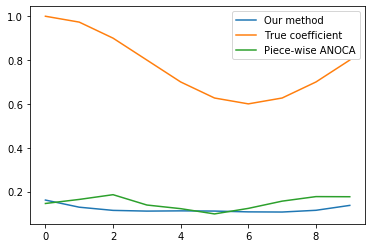

In [204]:
import matplotlib.pyplot as plt

plt.plot(range(time_stamp),np.mean(average_coef_list_new[:,:,4,2],0))
plt.plot(range(time_stamp),[cos(i) for i in range(time_stamp)])
plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,2,4],0))#ANOCA
# Function add a legend  
plt.legend(["Our method", "True coefficient", "Piece-wise ANOCA"])
  
# function to show the plot
plt.show()

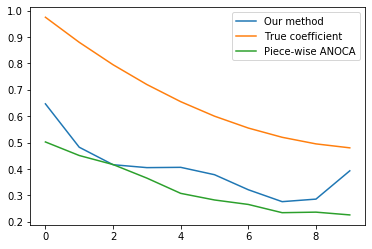

In [205]:
import matplotlib.pyplot as plt

plt.plot(range(time_stamp),np.mean(average_coef_list_new[:,:,3,0],0))
plt.plot(range(time_stamp),[quadratic(i) for i in range(time_stamp)])
plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,0,3],0))#ANOCA
# Function add a legend  
plt.legend(["Our method", "True coefficient", "Piece-wise ANOCA"])
  
# function to show the plot
plt.show()

In [143]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  0.8 ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

(30, 10, 5, 5)

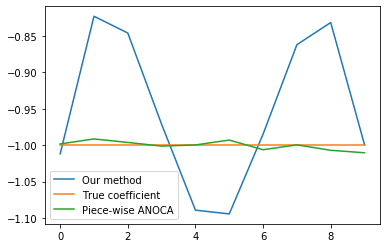

In [206]:
plt.plot(range(time_stamp),np.mean(average_coef_list_new[:,:,1,0],0))
plt.plot(range(time_stamp),[-1]*time_stamp)
# Function add a legend  
plt.legend(["Estimated coeffcient", "True coefficient"])
plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,0,1],0))#ANOCA
# Function add a legend  
plt.legend(["Our method", "True coefficient", "Piece-wise ANOCA"])
  
# function to show the plot
plt.show()

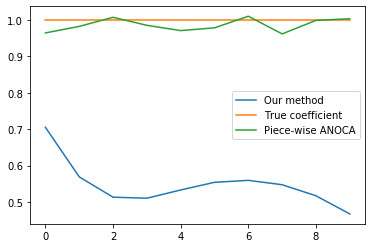

In [207]:
plt.plot(range(time_stamp),np.mean(average_coef_list_new[:,:,1,2],0))
plt.plot(range(time_stamp),[1]*time_stamp)
plt.plot(range(time_stamp),np.mean(average_coef_list[:,:,2,1],0))#ANOCA
# Function add a legend  
plt.legend(["Our method", "True coefficient", "Piece-wise ANOCA"])
# Function add a legend  
#plt.legend(["Estimated coeffcient", "True coefficient"])
  
# function to show the plot
plt.show()

In [210]:
diff_list=average_coef_list[:,:,2,4]-[cos(i) for i in range(time_stamp)]
np.square(diff_list).mean()

0.46725722870304937

In [211]:
diff_list_new=average_coef_list_new[:,:,4,2]-[cos(i) for i in range(time_stamp)]
np.square(diff_list_new).mean() ##MSE slightly smaller for cos(i)

0.44794397440880573

In [212]:
np.square(diff_list).std()/math.sqrt(30)

0.07144666741911947

In [213]:
np.square(diff_list_new).std()/math.sqrt(30)

0.03668993480278108

In [218]:
diff_list_2=average_coef_list[:,:,3,0]-[quadratic(i) for i in range(time_stamp)]
np.square(diff_list_2).mean() ##similar

0.47182894369325085

In [219]:
diff_list_new_2=average_coef_list_new[:,:,0,3]-[quadratic(i) for i in range(time_stamp)]
np.square(diff_list_new_2).mean()

0.4718281289467952

In [255]:
df_new.mean()##new method

FDR       0.097889
TPR       0.689167
SHD       1.643333
time    329.883348
dtype: float64

In [256]:
df.mean() ## ANOCA

FDR       0.254159
TPR       0.714167
SHD       2.353333
time    374.736947
dtype: float64

In [192]:
df_new.std()/np.sqrt(30)

FDR     0.013355
TPR     0.008190
SHD     0.064804
time    5.241719
dtype: float64

In [193]:
df.std()/np.sqrt(30)

FDR     0.020488
TPR     0.018363
SHD     0.121365
time    1.506442
dtype: float64

In [247]:
y = np.array([cos(i) for i in x])
#y = np.array([1 for i in x])
z= np.array([quadratic(i) for i in x])

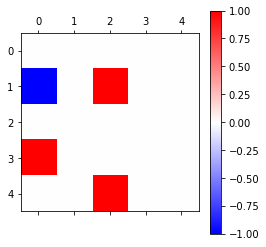

In [234]:
##True ##time 0
aa=base_DAG

plt.matshow(aa.T, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

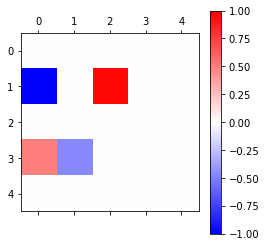

In [237]:
##ANOCA
bb=average_coef_list[:,0,:,:].mean(axis=0).T
bb[abs(bb)<0.3]=0
plt.matshow(bb, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

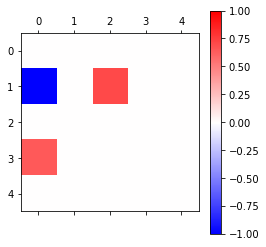

In [239]:
##new, time0
bb=average_coef_list_new[:,0,:,:].mean(axis=0)
bb[abs(bb)<0.3]=0
plt.matshow(bb, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

In [230]:
base_DAG

array([[ 0.  , -1.  , -0.  ,  0.48,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  1.  , -0.  ,  0.  ,  1.  ],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

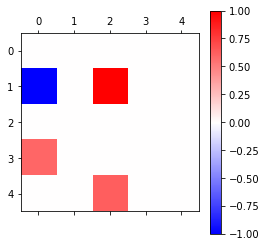

In [248]:
##True ##time 5
aa=base_DAG
aa[2,4]=y[5]##edited to be coeffcient with error
aa[0,3]=z[5]###multiple

plt.matshow(aa.T, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

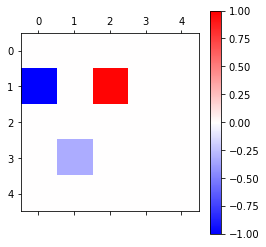

In [241]:
##ANOCA
bb=average_coef_list[:,5,:,:].mean(axis=0).T
bb[abs(bb)<0.3]=0
plt.matshow(bb, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

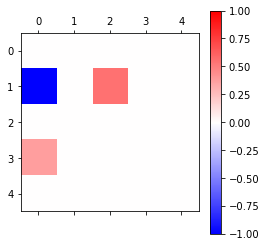

In [240]:
##new, time5
bb=average_coef_list_new[:,5,:,:].mean(axis=0)
bb[abs(bb)<0.3]=0
plt.matshow(bb, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

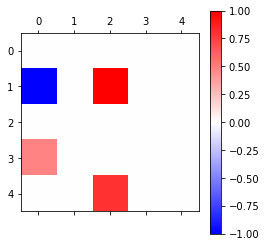

In [249]:
##True ##time 9
aa=base_DAG
aa[2,4]=y[9]##edited to be coeffcient with error
aa[0,3]=z[9]###multiple

plt.matshow(aa.T, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

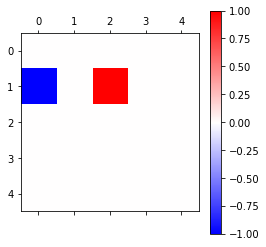

In [243]:
##ANOCA, time9
bb=average_coef_list[:,9,:,:].mean(axis=0).T
bb[abs(bb)<0.3]=0
plt.matshow(bb, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

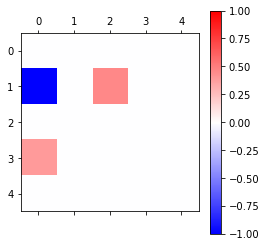

In [244]:
##new, time9
bb=average_coef_list_new[:,9,:,:].mean(axis=0)
bb[abs(bb)<0.3]=0
plt.matshow(bb, cmap = 'bwr', vmin = -1, vmax = 1)
fig1 = plt.gcf()
plt.colorbar()
plt.show()

In [71]:
true_value=([abs(cos(i))>0.4 for i in x])
estimated=abs(average_coef_list_new)>0.4
count_new=[]
for replicate in range(len(estimated)):
    count_each=0
    for i in range(len(true_value)):
        if true_value[i]==1 and estimated[replicate][i]==1:
            count_each+=1
    count_new.append(count_each)

In [75]:
mean(count)

13

In [74]:
mean(count_new)

11.133333333333333